Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training an Object Detection model using AutoML
In this notebook, we go over how you can use AutoML for training an Object Detection model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios. For detailed information please refer to the [documentation of AutoML for Images](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models).

![img](example_object_detection_predictions.jpg)

**Important:** This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see [Supplemental Terms of Use for Microsoft Azure Previews](https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/).

## Environment Setup
Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

In [77]:
!pip install --upgrade azureml-sdk

Requirement already up-to-date: azureml-sdk in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.38.0)


In [78]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

This notebook was created using version 1.35.0 of the Azure ML SDK.
You are currently using version 1.38.0 of the Azure ML SDK.


In [79]:
import cv2
import numpy as np
import torch
import time
import torchvision
from PIL import Image
from typing import Any, Dict, List

## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [84]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
ws.get_details()


{'id': '/subscriptions/83da1f6b-22c0-4300-aa13-bd260eab57e5/resourceGroups/amldatalabeling/providers/Microsoft.MachineLearningServices/workspaces/Computer_Vision_Pipeline',
 'name': 'Computer_Vision_Pipeline',
 'identity': {'principal_id': '91200a66-f1b4-4077-860a-4d115e873bc5',
  'tenant_id': '72f988bf-86f1-41af-91ab-2d7cd011db47',
  'type': 'SystemAssigned'},
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': 'd869dd80-1333-484d-99ae-5869dc1b041a',
 'sdkTelemetryAppInsightsKey': '71fa86c2-fe23-49db-bb2e-8537edfb6ead',
 'description': '',
 'friendlyName': 'Computer_Vision_Pipeline',
 'creationTime': '2021-05-17T20:54:23.0413693+00:00',
 'containerRegistry': '/subscriptions/83da1f6b-22c0-4300-aa13-bd260eab57e5/resourceGroups/amldatalabeling/providers/Microsoft.ContainerRegistry/registries/d869dd801333484d99ae5869dc1b041a',
 'keyVault': '/subscriptions/83da1f6b-22c0-4300-aa13-bd260eab57e5/resourcegroups/amldatala

## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [85]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-cluster-nc6"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=600,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [87]:
from azureml.core import Experiment

experiment_name = "automl-image-object-detection_latest_V3"
experiment = Experiment(ws, name=experiment_name)

## Dataset with input Training Data

Using the AML Labeling tool you labeled your images and exported the annotations as an AML ML Dataset. Now we need to a training_dataset to associate with that export using its name.

In [88]:
training_dataset = Dataset.get_by_name(ws, name='SodaDemo_20220126_131830')

Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-agnostic-hyperparameters) for more details.

This is what the training dataset looks like:

In [89]:
training_dataset.to_pandas_dataframe()

,image_url,label,label_confidence
0,computervisionwimagesraw/fa45f236-b599-11eb-8f...,"[{'label': 'sprite', 'topX': 0.320216286945812...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
1,computervisionwimagesraw/895849dc-b4dd-11eb-a2...,"[{'label': 'sprite', 'topX': 0.185364070197044...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,computervisionwimagesraw/45.jpg,"[{'label': 'sprite', 'topX': 0.078679938956714...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,computervisionwimagesraw/b34aa738-b598-11eb-8f...,"[{'label': 'coke', 'topX': 0.3115955972906404,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,computervisionwimagesraw/74.jpg,"[{'label': 'sprite', 'topX': 0.221694119458128...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
...,...,...,...
236,computervisionwimagesraw/a19fb52e-b4f2-11eb-9c...,"[{'label': 'diet_coke', 'topX': 0.209645532741...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
237,computervisionwimagesraw/e45261d0-b599-11eb-8f...,"[{'label': 'sprite', 'topX': 0.228467518472906...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
238,computervisionwimagesraw/80.jpg,"[{'label': 'sprite', 'topX': 0.220744311875693...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
239,computervisionwimagesraw/7170d386-b599-11eb-8f...,"[{'label': 'sprite', 'topX': 0.293738454433497...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:

In [90]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_yolov5 = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    #validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("yolov5")}),
    iterations=1,
)

## Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [91]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection_latest_V3,AutoML_4c9f2ac8-7502-448d-a000-e57f280bc018,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
automl_image_run.wait_for_completion(wait_post_processing=True)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab:

## Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [62]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)

## Download the model and other associated files e.g. labels

In [63]:
#https://github.com/MicrosoftDocs/azure-docs/blob/master/articles/machine-learning/how-to-inference-onnx-automl-image-models.md
# Create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

# Download the model from run history
best_child_run.download_file(name='train_artifacts/model.onnx',
output_file_path='./model/model.onnx')

best_child_run.download_file(name='train_artifacts/labels.json',
output_file_path='./model/labels.json')


###  ***Optional: if you trained the model earlier you can still down load the model and label  using Run id. This will be the highest level run id from a child run perspective

In [35]:
# Select the best child run
from azureml.train.automl.run import AutoMLRun
import json

run_id = "AutoML_a756bc5d-d85a-4178-9c36-0877cdc6dfbf" # Specify the run ID
automl_image_run = AutoMLRun(experiment=experiment, run_id=run_id)
best_child_run = automl_image_run.get_best_child()

labels_file = "./model/labels.json"
best_child_run.download_file(name="train_artifacts/labels.json", output_file_path=labels_file)

onnx_model_path = "./model/model.onnx"
best_child_run.download_file(name="train_artifacts/model.onnx", output_file_path=onnx_model_path)

## Load the labels and ONNX model files

In [12]:
import onnxruntime
import json

labels_file = "./model/labels.json"
onnx_model_path = "./model/model.onnx"


with open(labels_file) as f:
    classes = json.load(f)
print(classes)
try:
    session = onnxruntime.InferenceSession(onnx_model_path)
    print("ONNX model loaded...")
except Exception as e: 
    print("Error loading ONNX file: ",str(e))

['coke', 'diet_coke', 'sprite']
ONNX model loaded...


## Get expected input and output details for an ONNX model

In [13]:
sess_input = session.get_inputs()
sess_output = session.get_outputs()
print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")

for idx, input_ in enumerate(range(len(sess_input))):
    input_name = sess_input[input_].name
    input_shape = sess_input[input_].shape
    input_type = sess_input[input_].type
    print(f"{idx} Input name : { input_name }, Input shape : {input_shape}, \
    Input type  : {input_type}")  

for idx, output in enumerate(range(len(sess_output))):
    output_name = sess_output[output].name
    output_shape = sess_output[output].shape
    output_type = sess_output[output].type
    print(f" {idx} Output name : {output_name}, Output shape : {output_shape}, \
    Output type  : {output_type}") 

No. of inputs : 1, No. of outputs : 4
0 Input name : input, Input shape : ['batch', 3, 640, 640],     Input type  : tensor(float)
 0 Output name : output, Output shape : ['batch', 25200, 8],     Output type  : tensor(float)
 1 Output name : 1397, Output shape : [1, 3, 80, 80, 8],     Output type  : tensor(float)
 2 Output name : 1745, Output shape : [1, 3, 40, 40, 8],     Output type  : tensor(float)
 3 Output name : 2093, Output shape : [1, 3, 20, 20, 8],     Output type  : tensor(float)


## Image Inferencing Preprocessing

In [14]:
#Add the helper module yolo_onnx_preprocessing_utils to the system path where python looks for modules
import sys
MODULE_FULL_PATH = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/rdurham1/code/Users/rdurham/GTC/'
sys.path.insert(1, MODULE_FULL_PATH)
import yolo_onnx_preprocessing_utils

In [15]:
from yolo_onnx_preprocessing_utils import preprocess

test_image_path = "automl_models_od_yolo/test_image1.jpg"
img_data, pad = preprocess(test_image_path)

In [70]:
def get_predictions_from_ONNX(onnx_session,img_data):
    """perform predictions with ONNX Runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: boxes, labels , scores 
    :rtype: list
    """
    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    # predict with ONNX Runtime
    output_names = [ output.name for output in sess_output]
    pred = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})
    return pred[0]

result = get_predictions_from_ONNX(session, img_data)

## Object detection with YOLO

In [71]:
print(type(result))
print(result)
#result1 = numpy.array(result)

<class 'numpy.ndarray'>
[[[ 7.07386398e+00 -7.18506813e-01  8.28315639e+00 ...  1.10902011e-01
    1.13330930e-01  1.25597984e-01]
  [ 1.50764675e+01 -3.00181866e-01  1.70064392e+01 ...  1.01098239e-01
    1.65704876e-01  9.79958475e-02]
  [ 2.23137054e+01 -2.10461140e-01  2.08745403e+01 ...  1.12768531e-01
    1.33263588e-01  1.56515896e-01]
  ...
  [ 5.61091003e+02  6.13042786e+02  1.94735489e+02 ...  1.17473722e-01
    1.00439787e-01  2.17482656e-01]
  [ 5.88441406e+02  6.14564209e+02  1.70734024e+02 ...  9.92861986e-02
    8.66377950e-02  2.08703935e-01]
  [ 6.18717346e+02  6.20994202e+02  3.44873749e+02 ...  7.16921985e-02
    5.08601069e-02  1.16781682e-01]]]


In [72]:
batch, channel, height_onnx, width_onnx = session.get_inputs()[0].shape
batch, channel, height_onnx, width_onnx

('batch', 3, 640, 640)

In [74]:
from yolo_onnx_preprocessing_utils import non_max_suppression, _convert_to_rcnn_output
import torch

result = non_max_suppression(
    torch.from_numpy(result),
    conf_thres=.1,
    iou_thres=.5)
label, image_shape = _convert_to_rcnn_output(result[0], height_onnx, width_onnx, pad)
boxes = np.array(label["boxes"])
labels = np.array(label["labels"])
labels = [label[0] for label in labels]
scores = np.array(label["scores"])
scores = [score[0] for score in scores]
boxes, labels, scores

(array([[3.7890430e+02, 3.0951779e+02, 5.3466077e+02, 4.8300000e+02],
        [7.0733765e+01, 3.2610934e+02, 2.0432529e+02, 4.8300000e+02],
        [5.1780922e+01, 7.0374451e+00, 2.0111438e+02, 3.1472781e+02],
        [3.7098639e+02, 5.0053406e-01, 5.3715607e+02, 3.0254944e+02],
        [2.2824718e+02, 3.1223508e+02, 3.6723035e+02, 4.8300000e+02],
        [2.1675662e+02, 3.8503723e+00, 3.5872348e+02, 3.0698529e+02]],
       dtype=float32),
 [1, 1, 1, 1, 1, 1],
 [0.87611943, 0.86323965, 0.83822596, 0.82624364, 0.82026017, 0.815408])

In [75]:
def _get_box_dims(image_shape, box):
    box_keys = ['topX', 'topY', 'bottomX', 'bottomY']
    height, width = image_shape[0], image_shape[1]

    box_dims = dict(zip(box_keys, [coordinate.item() for coordinate in box]))

    box_dims['topX'] = box_dims['topX'] * 1.0 / width
    box_dims['bottomX'] = box_dims['bottomX'] * 1.0 / width
    box_dims['topY'] = box_dims['topY'] * 1.0 / height
    box_dims['bottomY'] = box_dims['bottomY'] * 1.0 / height

    return box_dims

def _get_prediction(boxes, labels, scores, image_shape, classes):
    bounding_boxes = []
    for box, label_index, score in zip(boxes, labels, scores):
        box_dims = _get_box_dims(image_shape, box)

        box_record = {'box': box_dims,
                      'label': classes[label_index],
                      'score': score.item()}

        bounding_boxes.append(box_record)

    return bounding_boxes

bounding_boxes = _get_prediction(boxes, labels, scores, (height_onnx,width_onnx), classes)
print(json.dumps(bounding_boxes, indent=1))

# Filter the results with a threshold.
# Replace the threshold for your test scenario.
score_threshold = 0.6
filtered_bounding_boxes = []
for box in bounding_boxes:
    if box['score'] >= score_threshold:
       filtered_bounding_boxes.append(box)

[
 {
  "box": {
   "topX": 0.5920379638671875,
   "topY": 0.48362154960632325,
   "bottomX": 0.8354074478149414,
   "bottomY": 0.7546875
  },
  "label": "diet_coke",
  "score": 0.8761194348335266
 },
 {
  "box": {
   "topX": 0.11052150726318359,
   "topY": 0.5095458507537842,
   "bottomX": 0.3192582607269287,
   "bottomY": 0.7546875
  },
  "label": "diet_coke",
  "score": 0.8632396459579468
 },
 {
  "box": {
   "topX": 0.08090769052505493,
   "topY": 0.010996007919311523,
   "bottomX": 0.3142412185668945,
   "bottomY": 0.4917622089385986
  },
  "label": "diet_coke",
  "score": 0.8382259607315063
 },
 {
  "box": {
   "topX": 0.5796662330627441,
   "topY": 0.0007820844650268555,
   "bottomX": 0.8393063545227051,
   "bottomY": 0.4727334976196289
  },
  "label": "diet_coke",
  "score": 0.8262436389923096
 },
 {
  "box": {
   "topX": 0.3566362142562866,
   "topY": 0.4878673076629639,
   "bottomX": 0.5737974166870117,
   "bottomY": 0.7546875
  },
  "label": "diet_coke",
  "score": 0.82026016

(816, 616)
diet_coke: 483.102978515625, 431.9707681083679, 198.5894989013671, 166.97662544250485
diet_coke: 90.18554992675782, 455.12635389328005, 170.329190826416, 151.0072559356689
diet_coke: 66.02067546844482, 9.821634273529051, 190.4001588821411, 296.15197982788084
diet_coke: 473.0076461791992, 0.6985578441619873, 211.86633911132813, 290.7220705032349
diet_coke: 291.0151508331299, 435.7630792045593, 177.20354118347166, 164.36123847961423
diet_coke: 276.36469345092775, 5.373675861358642, 181.00774383544928, 291.7673587799072


<Figure size 1296x864 with 0 Axes>

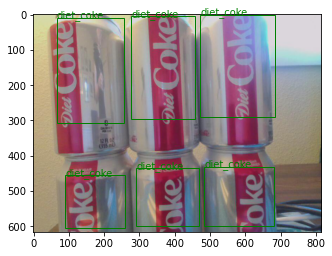

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image_path)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
print(img.size)

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(img_np)

# Draw a box and label for each detection 
for detect in filtered_bounding_boxes:
    label = detect['label']
    box = detect['box']
    ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
    topleft_x, topleft_y = x  * 1* xmin, y * 1.45 * ymin
    width, height = x * (xmax - xmin), y * (ymax - ymin)
    print('{}: {}, {}, {}, {}'.format(detect['label'], topleft_x, topleft_y, width, height))
    rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                             linewidth=1, edgecolor='green',facecolor='none')

    ax.add_patch(rect)
    color = 'green'
    plt.text(topleft_x, topleft_y, label, color=color)

plt.show()